# Least Squares Revisited

Now that we have started working with multivariate vector functions, there is a useful tool that depends on them in `Scipy.optimize` - least_squares.

This routine accomplishes the same things that we did in Supplement 11 for the Michaelis-Menten example; however, it is specifically designed for nonlinear least squares and offers some nice options like robust fitting, whereas `opt.minimize()` just minimizes the function that we supply to it.  In general, writing alternative "least squares" algorithms and properly scaling data requires a good understanding of the methods and the data, and the `opt.least_squares()` algorithm is built to handle some of this for us. The major difference between `opt.minimize()` and `opt.least_squares()` (other than the latter being specifically designed for least squares problem) is that `opt.minimize()` works on a scalar function (i.e., a function that returns the sum of squares), while `opt.least_squares()` works on a vector function.  Specifically, we provide `opt.least_squares()` with a function that calculates the vector of residuals, the difference between measurement and model, that includes every data point, and then `opt.least_squares()` generates the objective function automatically from that full vector of residuals. Revisiting that Michaelis-Menten example, let's load the data again:

In [1]:
CS = np.array([0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]) #mmol/L
rate = np.array([0, 0.017537467, 0.030941975, 0.080327165, 0.1643835, 0.26569368, 0.745442547, 1.295792328, 2.419014706, 4.0402125, 5.534947297, 5.127217742, 7.074911496]) #mmol/L/min

NameError: name 'np' is not defined

### Write a multivariate vector function that returns an array of residuals

Now we'll set up the least squares problem by creating a function that returns a *vector* of residuals for each data point; we still need it to take variable parameters ($V_{max}$ and $K_m$) as a vector input, and we have to pass that input as the first argument to the function.  We also need to pass our experimental concentrations and rates in order to calculate model predictions and residuals:

In [16]:
def resid(par, Cexp, rexp):
    Vmax, Km = par
    rmod     = (Vmax*Cexp)/(Km + Cexp)
    residual = (rexp - rmod)
    return     residual

#Test the function for an initial guess of $V_{max} = 7$ and $K_m = 0.4$.
par0 = [7, 0.4]
resid(np.array([7,0.4]), CS, rate) 

array([ 0.00000000e+00,  8.11078978e-05, -3.88389565e-03, -6.09258809e-03,
       -6.34820732e-03, -6.76396533e-02, -3.23352308e-02, -1.04207672e-01,
        8.56813727e-02,  1.51323611e-01,  5.34947297e-01, -7.06115591e-01,
        5.93430015e-01])

### Find best fit parameters using `opt.least_squares()`

Now that we have a function that returns residuals when we provide 1) the parameter set, 2) experimental concentrations, and 3) experimental rates, we are ready to use opt.least_squares to find optimal values for $V_{max}$ and $K_m$.  I'm using the args keyword to pass CS and rate to the function, and I'm adding the `verbose` keyword to ask for a detailed output of iteration progress.

In [17]:
par0 = np.array([7, 0.4])
opt.least_squares(resid, par0, args = (CS, rate), verbose = 2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9187e-01                                    1.49e+00    
       1              2         5.5471e-01      3.72e-02       2.06e-01       9.68e-03    
       2              3         5.5471e-01      8.21e-07       5.00e-04       9.26e-06    
       3              4         5.5471e-01      1.91e-12       1.68e-06       8.12e-08    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 5.9187e-01, final cost 5.5471e-01, first-order optimality 8.12e-08.


 active_mask: array([0., 0.])
        cost: 0.5547124699052083
         fun: array([ 0.00000000e+00, -2.85817665e-05, -4.10469633e-03, -6.65500328e-03,
       -7.50616083e-03, -7.00769297e-02, -3.91501641e-02, -1.19326840e-01,
        5.33159251e-02,  7.73111889e-02,  4.21195403e-01, -8.55199246e-01,
        4.13562724e-01])
        grad: array([-3.07683062e-09,  8.12494461e-08])
         jac: array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.43749831e-03,  4.28172126e-02],
       [-4.86314275e-03,  8.52184794e-02],
       [-1.20698110e-02,  2.09971659e-01],
       [-2.38517360e-02,  4.09986667e-01],
       [-4.65921676e-02,  7.82214008e-01],
       [-1.08871577e-01,  1.70839684e+00],
       [-1.96364628e-01,  2.77879338e+00],
       [-3.28268859e-01,  3.88292611e+00],
       [-5.49899715e-01,  4.35839659e+00],
       [-7.09593931e-01,  3.62868726e+00],
       [-8.30131551e-01,  2.48309654e+00],
       [-9.24341422e-01,  1.23147213e+00]])
     message: '`ftol` termination condition

### Adding bounds to `opt.least_squares()` parameters

You can add bounds to this routine when using either trf or dogbox algorithms. Note that the structure of the bounds here is different from `opt.minimize()`; it is like the convention used for `opt.curve_fit()`. Here, the bounds argument is always formatted as $[(\textrm{lower bounds}), (\textrm{upper bounds})]$, where lower bounds and upper bounds are tuples that contain the lower bound on each parameter (in the same sequence as the parameters are packed into par), and upper bound contains the corresponding upper bounds.

In [18]:
opt.least_squares(resid, par0, method = 'trf', args = (CS, rate), verbose = 2, bounds = [(6.8, 0.1), (7.5, 0.6)])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9187e-01                                    4.46e-01    
       1              2         5.5906e-01      3.28e-02       1.11e-01       3.65e-02    
       2              3         5.5490e-01      4.16e-03       7.66e-02       5.73e-03    
       3              4         5.5471e-01      1.86e-04       1.90e-02       3.22e-04    
       4              5         5.5471e-01      7.58e-07       1.28e-03       5.86e-06    
       5              6         5.5471e-01      5.46e-11       1.02e-05       5.73e-08    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 5.9187e-01, final cost 5.5471e-01, first-order optimality 5.73e-08.


 active_mask: array([0, 0])
        cost: 0.55471246990521
         fun: array([ 0.00000000e+00, -2.85823108e-05, -4.10469741e-03, -6.65500594e-03,
       -7.50616601e-03, -7.00769395e-02, -3.91501850e-02, -1.19326873e-01,
        5.33158832e-02,  7.73111544e-02,  4.21195392e-01, -8.55199230e-01,
        4.13562768e-01])
        grad: array([-3.41376827e-09, -3.00587740e-07])
         jac: array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.43749840e-03,  4.28172159e-02],
       [-4.86314292e-03,  8.52184854e-02],
       [-1.20698116e-02,  2.09971674e-01],
       [-2.38517370e-02,  4.09986697e-01],
       [-4.65921700e-02,  7.82214060e-01],
       [-1.08871580e-01,  1.70839695e+00],
       [-1.96364633e-01,  2.77879353e+00],
       [-3.28268870e-01,  3.88292629e+00],
       [-5.49899728e-01,  4.35839668e+00],
       [-7.09593937e-01,  3.62868738e+00],
       [-8.30131558e-01,  2.48309654e+00],
       [-9.24341421e-01,  1.23147207e+00]])
     message: '`ftol` termination condition is 

### Why would I use `opt.least_squares()` instead of `opt.minimize()`?

One thing I can point to is that this algorithm will return the Jacobian/Hessian approximations, which you can use to estimate confidence intervals on your parameters (not covered here).  Another nice feature of `opt.least_squares()` is that it provides you with a few options for generating the loss function for more robust curve fitting. The default option is 'linear', which generates a standard SSE as the cost function. There are also `soft_l1`, `huber`, `cauchy`, and `arctan`, which may do a better job of handling outliers in the data set.  As an illustration, here is the optimal fit generated using default options; we will plot it against the experimental data; we'll also print out the parameter values and the loss function value at the optimum.

Vmax and Km are [7.20658909 0.40925669]
The minimum of the objective function is 0.5547124699052083


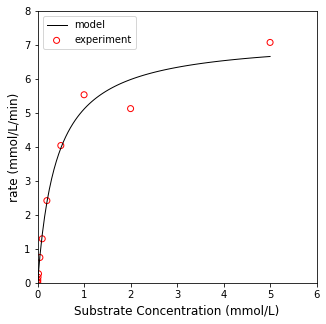

In [19]:
import matplotlib.pyplot as plt
sol = opt.least_squares(resid, par0, args = (CS, rate))
print('Vmax and Km are', sol.x)
print('The minimum of the objective function is', sol.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)

plt.figure(1, figsize = (5, 5))
plt.plot(Cmodel, modfun(sol.x[0], sol.x[1], Cmodel), color = 'black', linewidth = 1, label = 'model')
plt.scatter(CS, rate, marker = 'o', color = 'none', edgecolor = 'red', label = 'experiment')
plt.xlim(0, 6)
plt.ylim(0, 8)
plt.xlabel('Substrate Concentration (mmol/L)', fontsize = 12)
plt.ylabel('rate (mmol/L/min)', fontsize = 12)
plt.legend()
plt.show()

Now let's contrast that with soft_l1 and cauchy loss functions.

Vmax and Km using standard sum of squares are [7.20658909 0.40925669]
Vmax and Km using soft_l1 are [7.30480124 0.41696168]
Vmax and Km using cauchy are [7.43013646 0.42680022]
The minimum of the objective function using standard sum of squares is 0.5547124699052083
The minimum of the objective function using soft_l1 is 0.4933646113402903
The minimum of the objective function using cauchy is 0.4321935995722679


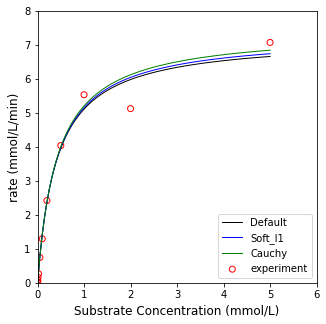

In [20]:
default = opt.least_squares(resid, par0, args = (CS, rate))
soft    = opt.least_squares(resid, par0, args = (CS, rate), loss = 'soft_l1')
cauchy  = opt.least_squares(resid, par0, args = (CS, rate), loss = 'cauchy')
print('Vmax and Km using standard sum of squares are', default.x)
print('Vmax and Km using soft_l1 are', soft.x)
print('Vmax and Km using cauchy are', cauchy.x)
print('The minimum of the objective function using standard sum of squares is', default.cost)
print('The minimum of the objective function using soft_l1 is', soft.cost)
print('The minimum of the objective function using cauchy is', cauchy.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)

plt.figure(1, figsize = (5, 5))
plt.plot(Cmodel, modfun(default.x[0], default.x[1], Cmodel), color = 'black', linewidth = 1, label = 'Default')
plt.plot(Cmodel, modfun(soft.x[0], soft.x[1], Cmodel), color = 'blue', linewidth = 1, label = 'Soft_l1')
plt.plot(Cmodel, modfun(cauchy.x[0], cauchy.x[1], Cmodel), color = 'green', linewidth = 1, label = 'Cauchy')
plt.scatter(CS, rate, marker = 'o', color = 'none', edgecolor = 'red', label = 'experiment')
plt.xlim(0, 6)
plt.ylim(0, 8)
plt.xlabel('Substrate Concentration (mmol/L)', fontsize = 12)
plt.ylabel('rate (mmol/L/min)', fontsize = 12)
plt.legend()
plt.show()

You should see a small difference in the parameter values and model fits and notice that the `soft_l1` and `cauchy` cost functions minimize the influence of what appears to be an outlier at about 2.0 mmol/L. I would not take a decrease in the cost function from `linear` to `soft_l1` to `cauchy` to be evidence of a better fit.  They formulate different cost functions, and so there is no good way to directly compare between them.  You would need to look at an $R^2$ for the model, confidence intervals on parameter estimates, and consider whether outlier rejection is appropriate or not based on statistical analysis - all of which is far beyond the scope of this Module.

```{info}
**Added Bonus**: `opt.least_squares()` even lets you generate your own cost function by providing a function with the `loss` keyword argument, but that is a fairly advanced topic.
```

Alternative loss functions use the f_scale parameter to determine the margin it uses to define what is an outlier, and it is usually of critical importance.  It's default value is 1 (set above). Try some different values for f_scale in the cell below. You can clearly see the difference it makes when we set f_scale to 2, 1, 0.5, and 0.1 for the soft_l1 loss function.  Again, this is an advanced topic. I would caution against too much manipulation without some pretty good background in statistics. I'm presenting it here just to give you a sense of the flexibility of the opt.least_squares package for advanced nonlinear regression.